In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

$\Large \epsilon y'' + p(x,y)y' + q(x,y) = 0, \quad y(0) = \alpha, y(1) = \beta, \quad x \in [0,1]$

$\Large \epsilon y'' + 2y' + e^y = 0, \quad y(0) = y(1) = 0, \quad 0 < \epsilon << 1$

### Sol. Aalítica*: $\rightarrow y(x) = -ln(\frac{1}{2}x + \frac{1}{2}) - ln(2)e^{\frac{-2x}{\epsilon}}$

In [2]:
alpha = beta = 0.
a, b = 0., 1.

In [3]:
def fd( u, v, w, t, a, b ):
    u = u(t)
    v = v(t)
    w = w(t)

    if type( t ) != np.ndarray:
        if type( t ) == list:
            t = np.array( t )
        else:
            t = np.array( [ float( t ) ] )

    n = len( t )

    if type( u ) == int or type( u ) == float:
        u = np.array( [ float( u ) ] * n )

    if type( v ) == int or type( v ) == float:
        v = np.array( [ float( v ) ] * n )

    if type( w ) == int or type( w ) == float:
        w = np.array( [ float( w ) ] * n )


    h = t[1] - t[0]

    A = -( 1.0 + w[1:n] * h / 2.0 )
    A[-1] = 0.0

    C = -( 1.0 - w[0:n-1] * h / 2.0 )
    C[0] = 0.0

    D = 2.0 + h * h * v
    D[0] = D[n-1] = 1.0

    B = - h * h * u
    B[0] = a
    B[n-1] = b

    # Solve tridiagonal system

    for i in range( 1, n ):
        xmult = A[i-1] / D[i-1]
        D[i] = D[i] - xmult * C[i-1]
        B[i] = B[i] - xmult * B[i-1]

    x = np.zeros( n )
    x[n-1] = B[n-1] / D[n-1]

    for i in range( n - 2, -1, -1 ):
        x[i] = ( B[i] - C[i] * x[i+1] ) / D[i]

    return x

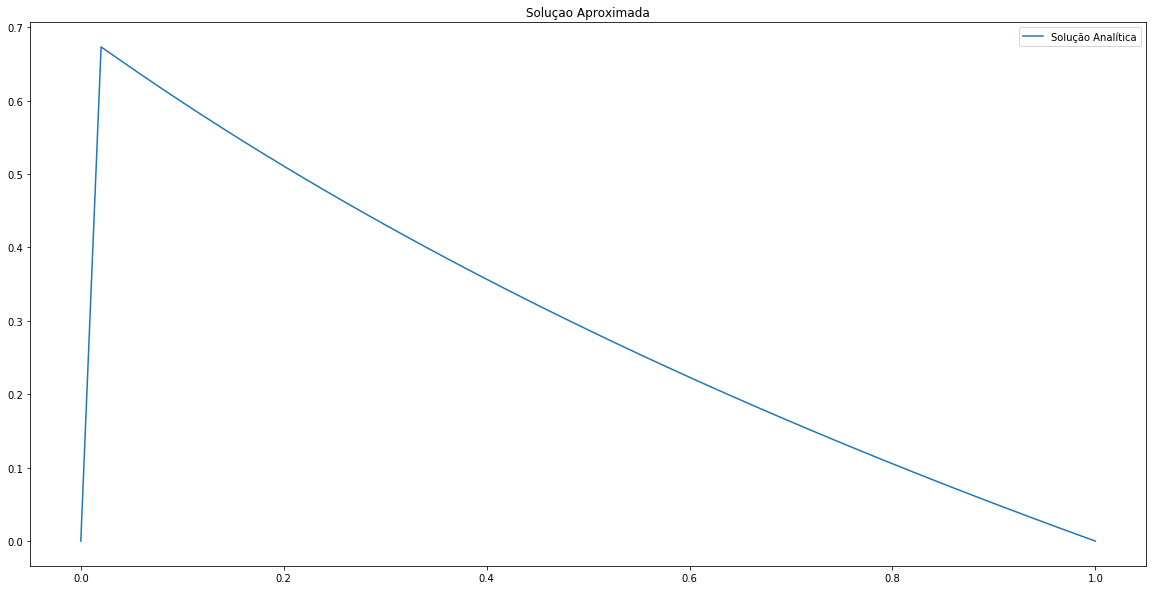

In [4]:
E = 0.005
x = np.linspace(a, b, 51).reshape((-1, 1))
res_fd = fd_central( u(t1), v(t1), w(t1), t1, y_a, y_b, method="central")

def analitic(x):
#     return np.log(2/(1+x))-np.log(2)*np.exp(-2*x / E)
    return -np.log(1/2*x + 1/2) -np.log(2)*np.exp(-2*x / E)
y_analitico = analitic(x)

plt.figure(figsize=(20,10))
plt.plot(x, y_analitico, label='Solução Analítica') 
plt.legend()
plt.title('Soluçao Aproximada')
plt.show()

# Resolvendo o Segundo Layer [PVI]

In [5]:
params1 = init_random_params(0.1, layer_sizes=[1, 20, 1])

In [6]:
# Definindo os apelidos para cada PVI
u = y
up = yp

In [7]:
def objective1(params, step):
    res = p(x, u(params, x))*up(params, x) + q(x, u(params, x))
    bc0 = u(params, b) - beta # igual a zero
    return np.mean(res**2) + bc0**2

In [8]:
def callback1(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step, objective1(params, step)))

x = np.linspace(a, b, 51).reshape((-1, 1))
params1 = adam(grad(objective1), params1,
      step_size=0.001, num_iters=10000, callback=callback1)

Iteration   0 objective [[0.812511]]
Iteration 1000 objective [[0.009853]]
Iteration 2000 objective [[0.000176]]
Iteration 3000 objective [[0.000105]]
Iteration 4000 objective [[0.000092]]
Iteration 5000 objective [[0.000075]]
Iteration 6000 objective [[0.000052]]
Iteration 7000 objective [[0.000028]]
Iteration 8000 objective [[0.000010]]
Iteration 9000 objective [[0.000003]]


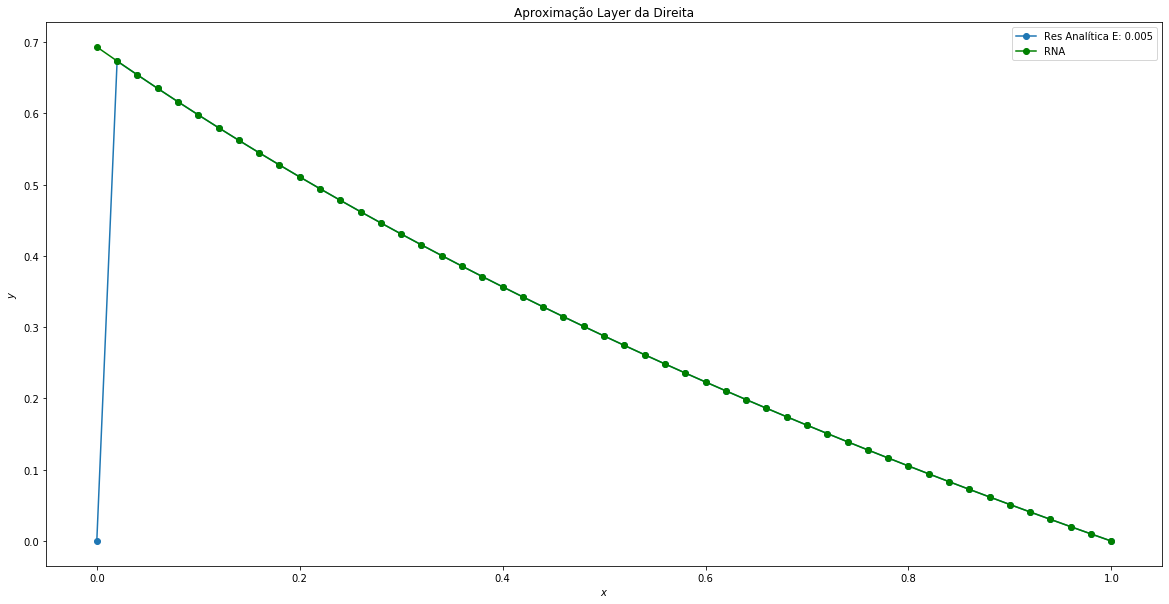

In [9]:
plt.figure(figsize=(20,10))
res = u(params1, x)
plt.plot(x, y_analitico, label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(x, res, label='RNA', color='green', marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Aproximação Layer da Direita')
plt.show()

# Resolvendo o Primeiro Layer [PVC]

In [10]:
sigma = np.min([1/2, E*np.log(x.shape[0])])
# sigma = 0.1
x = np.linspace(a, sigma, 51).reshape((-1, 1))

params2 = init_random_params(0.1, layer_sizes=[1, 20, 1])
# Definindo os apelidos
v = y
vp = yp
vpp = ypp

In [11]:
zero = np.broadcast_to(np.array([0.0]),(x.shape[0],1))
t = x/E
def objective2(params, step):
    
    res = vpp(params, t) + p(zero, v(params, t))*vp(params, t) + E*v(params, t)
    bc0 = v(params, a) - alpha
    bc1 = v(params, t[-1]) - u(params1, t[-1]*E)
    return np.mean(res**2) + bc0**2 + bc1**2

In [12]:
# print(objective2(params2, x))
def callback2(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step, objective2(params, step)))

params2 = adam(grad(objective2), params2,
      step_size=0.001, num_iters=10000, callback=callback2)

Iteration   0 objective [[1.011782]]
Iteration 1000 objective [[0.072651]]
Iteration 2000 objective [[0.062912]]
Iteration 3000 objective [[0.010712]]
Iteration 4000 objective [[0.003083]]
Iteration 5000 objective [[0.000392]]
Iteration 6000 objective [[0.000080]]
Iteration 7000 objective [[0.000038]]
Iteration 8000 objective [[0.000017]]
Iteration 9000 objective [[0.000008]]


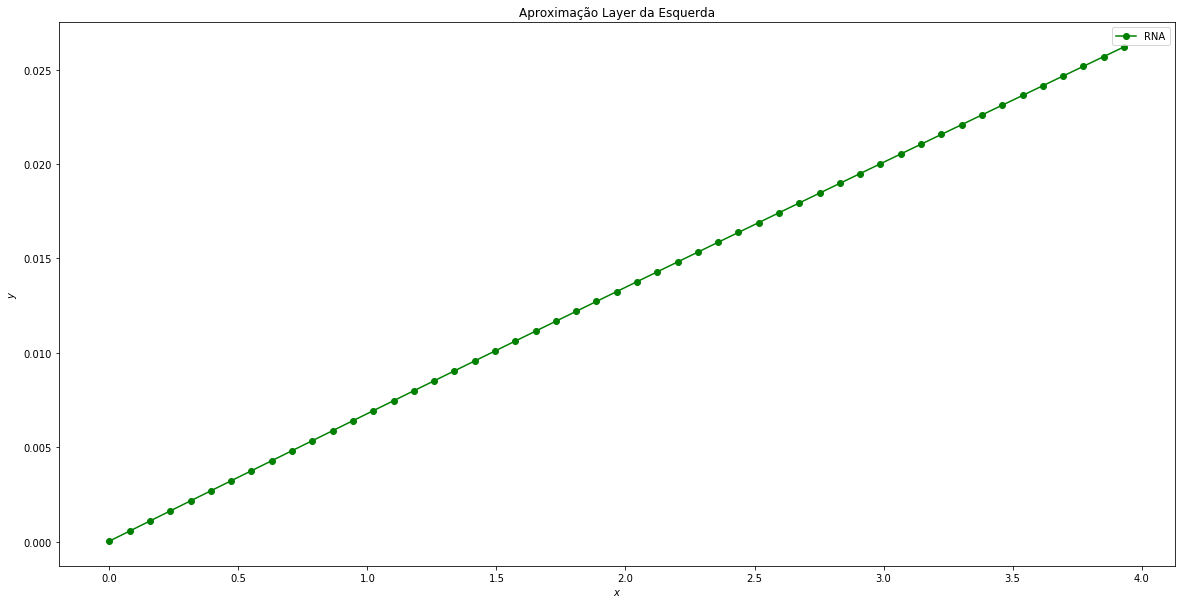

In [13]:
plt.figure(figsize=(20,10))
res = v(params2, x)

# plt.plot(x, y_analitico, label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(t, res, label='RNA', color='green', marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Aproximação Layer da Esquerda')
plt.show()

# Unindo as Duas Redes para Fomar y

In [14]:
def particionar(x, tf):
    return (np.array([d[0] for d in x if d <= tf]).reshape((-1, 1)), np.array([d[0] for d in x if d > tf]).reshape((-1, 1)))

def y_aprox(x):
    t = x/E
    inner, outer = particionar(x, sigma)             
    inner = v(params2, inner/E)
    outer = u(params1, outer)
    return np.concatenate((inner, outer), axis=0)

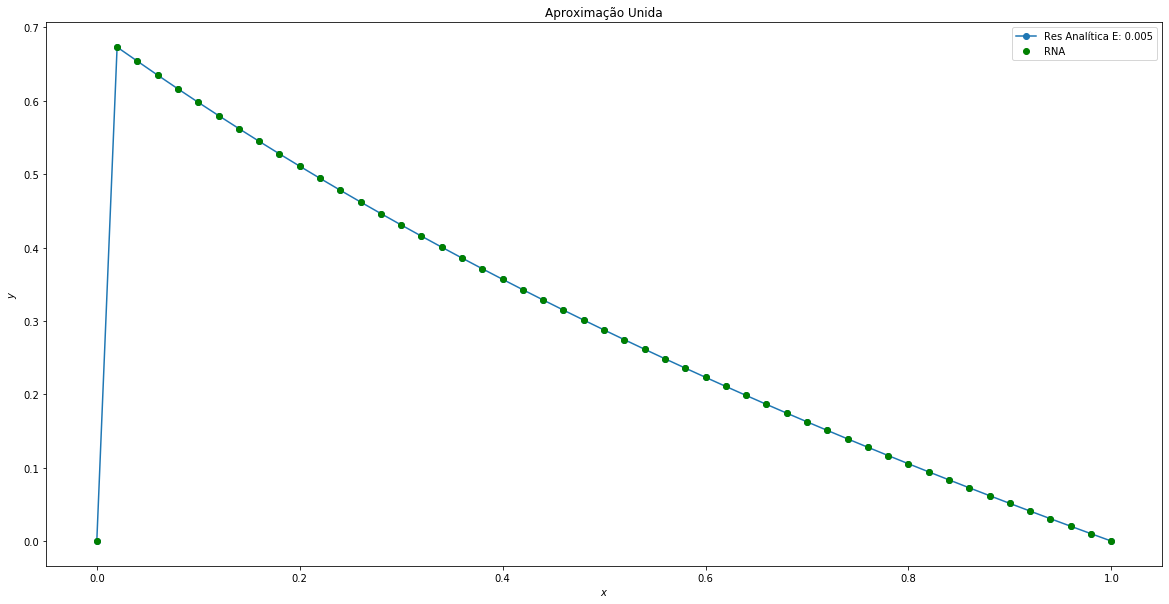

In [21]:
x = np.linspace(a, b, 51).reshape((-1, 1))
plt.figure(figsize=(20,10))
res = y_aprox(x)
plt.plot(x, analitic(x), label='Res Analítica E: {}'.format(E), marker='o')
plt.plot(x, res, label='RNA', color='green', linestyle="", marker='o')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Aproximação Unida')
plt.show()